# Correlation of the ROIs with the NSD image categories
* Also example of NSD_ann class usage

In [3]:
# in case you want to reclone repo and cannot delete the directory
# import shutil
# shutil.rmtree('gallirallus')

# @title get modules
! git clone https://github.com/mkmohan003/gallirallus.git
! pip install pycocotools
! pip install nilearn==0.9.2

Cloning into 'gallirallus'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 48 (delta 13), reused 25 (delta 4), pack-reused 0
Unpacking objects: 100% (48/48), 2.18 MiB | 3.91 MiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 77.2 MB/s eta 0:00:00


In [4]:
from gallirallus.dataops.nsd_annot import NSD_ann
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

/content/gallirallus/resource


In [5]:
# this takes a while
ann = NSD_ann(platform='colab')

Mounted at /content/drive/
loading COCO image annotations
loading annotations into memory...
Done (t=22.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading NSD image infos
Creating hash table between NSD img id and cocoId and coco split
loading success!


In [6]:
# @title Category IDs for list of NSD image IDs
categories = ann.nsd_cat([1, 2, 3])
print(categories)

{1: [17, 70], 2: [44, 44, 67, 1, 46, 46, 50, 51, 59, 48], 3: [54, 62, 67, 47, 49, 1, 62, 54]}


In [7]:
nsd_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data'
subj = 1

class argObj:
  def __init__(self, data_dir, subj):

    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

args = argObj(nsd_dir, subj)

In [8]:
# @title Load fMRI
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


In [9]:
def get_roi_class(roi):
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'
  return roi_class

In [10]:
hemisphere = 'left'
roi = "V1v"
roi_class = get_roi_class(roi)

# Load the ROI brain surface maps
roi_class_dir = os.path.join(
    args.data_dir,
    'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')

roi_map_dir = os.path.join(
    args.data_dir,
    'roi_masks',
    'mapping_'+roi_class+'.npy')

fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

(163842,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


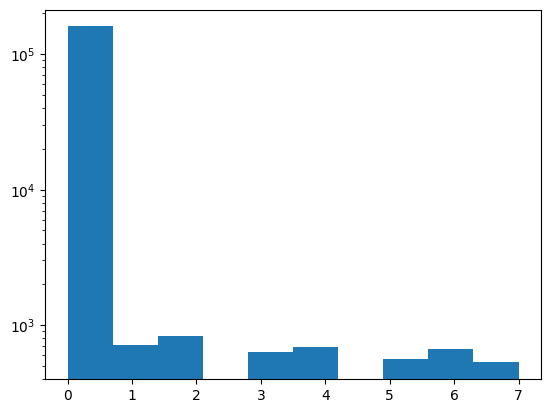

In [11]:
# fsaverage_roi_class is mosty zeros, values 1-7 are for 'prf-visualrois' ROIs which are 7
print(fsaverage_roi_class.shape, fsaverage_roi_class[155007:155057])
plt.hist(fsaverage_roi_class)
plt.yscale('log')
plt.show()

In [12]:
# This is hash map between ROI and integers in the fsaverage_roi_class
roi_map

{0: 'Unknown',
 1: 'V1v',
 2: 'V1d',
 3: 'V2v',
 4: 'V2d',
 5: 'V3v',
 6: 'V3d',
 7: 'hV4'}

In [13]:
# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]  # int, key corresponding to Roi from roi_map dict
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

In [14]:
# I labeled 1 all positions which belong to my ROI
fsaverage_roi.shape, sum(fsaverage_roi)

((163842,), 710)

In [15]:
# Create the interactive brain surface map
# just a region, no fmri data
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
view = plotting.view_surf(
    surf_mesh=fsaverage['infl_'+hemisphere],
    surf_map=fsaverage_roi,
    bg_map=fsaverage['sulc_'+hemisphere],
    threshold=1e-14,
    cmap='cool',
    colorbar=False,
    title=roi+', '+hemisphere+' hemisphere'
    )
view

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# @title Load NSD images
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 9841
Test images: 159


In [17]:
train_img_file = train_img_list[0]
print('Training image file name: ' + train_img_file)
print('73k NSD images ID: ' + train_img_file[-9:-4])

Training image file name: train-0001_nsd-00013.png
73k NSD images ID: 00013


In [18]:
# dictionary of categories for selected images, only one in this case
img = int(train_img_file[-9:-4])
cat_imgs = ann.nsd_cat(img)

In [19]:
# In one image, there are many categories
[ann.coco_train.cats[k] for k in cat_imgs[img]]

[{'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
 {'supercategory': 'furniture', 'id': 63, 'name': 'couch'},
 {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'},
 {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'},
 {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'},
 {'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
 {'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
 {'supercategory': 'indoor', 'id': 84, 'name': 'book'}]

In [21]:
# @title Here only for supercategories
# challenge roi is necessary to map 19000 fmri point onto 160 000 voxels
# from the brain database
img = 0
roi = 'V1v'
hemisphere = 'left'
roi_class = get_roi_class(roi)

challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

def fmri_roi(fs_av_roi, img, hemi, challenge_roi):
  # Map the fMRI data onto the brain surface map
  fsaverage_response = np.zeros(len(fsaverage_roi))
  if hemisphere == 'left':
      fsaverage_response[np.where(fsaverage_roi)[0]] = lh_fmri[img, np.where(challenge_roi)[0]]
  elif hemisphere == 'right':
      fsaverage_response[np.where(fsaverage_roi)[0]] = rh_fmri[img, np.where(challenge_roi)[0]]
  return fsaverage_response, fsaverage_response[np.where(fsaverage_roi)[0]]


fsaverage_response, froi = fmri_roi(fsaverage_roi, img, hemisphere, challenge_roi)

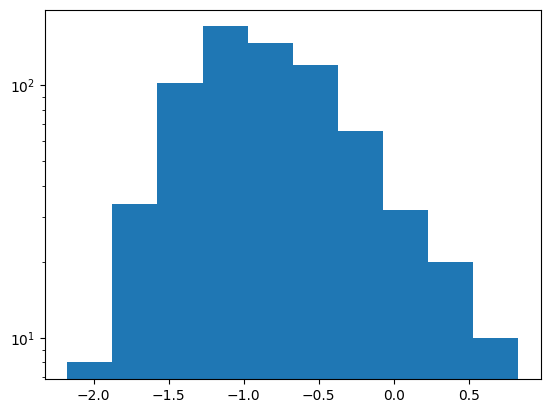

In [23]:
# Histogram of fMRI response of roi without zeros from other not selected ROIs
plt.hist(froi)
plt.yscale('log')

In [24]:
# @title Hardcode Supercategories, not ideal
supcats = {'outdoor': 0,
          'food': 1,
          'indoor': 2,
          'appliance': 3,
          'sports': 4,
          'person': 5,
          'animal': 6,
          'vehicle': 7,
          'furniture': 8,
          'accessory': 9,
          'electronic': 10,
          'kitchen': 11,
}

In [29]:
# I want to correlate all the images and add corr to fields of the superclasses I think
# do first 10 images
full_corr = []

# this scales like O(n**3) perhaps, with 1000 you will wait quite a bit
n = 500

# correlation array
full_corr = np.zeros((len(supcats.keys()),
                      len(supcats.keys())),
                     )
# count array, to normalize full_corr in the end by division.
counts = np.zeros((len(supcats.keys()),
                   len(supcats.keys())),
                  )

# iterate over all pairs of images
for i in range(0, n):
  for j in range(i+1, n):
    _, roi_respi = fmri_roi(fsaverage_roi, i, hemisphere, challenge_roi)
    _, roi_respj = fmri_roi(fsaverage_roi, j, hemisphere, challenge_roi)

    # correlation, maybe should be Pearsons??
    corr = np.corrcoef(roi_respi, roi_respj)[0, 1]

    # use NSD_ann to get the supercategories for first image
    nsdi = int(train_img_list[i][-9:-4])
    cat_imgsi = ann.nsd_cat([nsdi])
    objectsi = [ann.coco_train.cats[k] for k in cat_imgsi[nsdi]]
    img_supcatsi = [k['supercategory'] for k in objectsi]
    img_supcats_indi = [supcats[k] for k in img_supcatsi]

    # same for the second one
    nsdj = int(train_img_list[j][-9:-4])
    cat_imgsj = ann.nsd_cat([nsdj])
    objectsj = [ann.coco_train.cats[k] for k in cat_imgsj[nsdj]]
    img_supcatsj = [k['supercategory'] for k in objectsj]
    img_supcats_indj = [supcats[k] for k in img_supcatsj]

    # go through all the pairs of supercategories for this pair of images
    for indi in img_supcats_indi:
      for indj in img_supcats_indj:
        # add correlations and counts to all the fields necessary
        full_corr[indi, indj] += corr
        full_corr[indj, indi] += corr
        counts[indi, indj] += 1
        counts[indj, indi] += 1
  print(f'\r iter {i}', end='')

scaled_corr = full_corr / counts

 iter 499

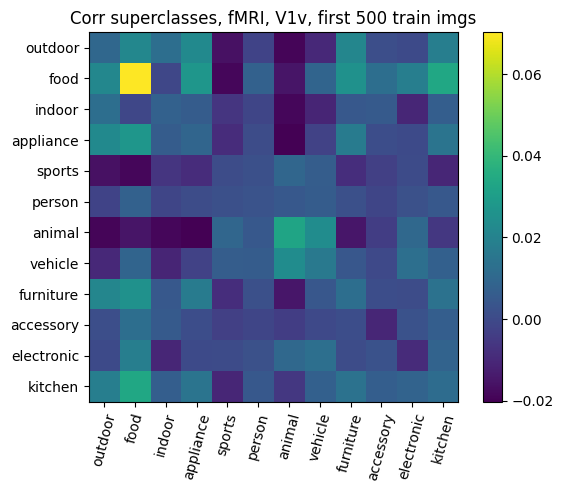

In [30]:
# The plot changes a lot depending on how many images you take, so it
# is not clear it identifies anything.
plt.imshow(scaled_corr, cmap='viridis') # cmap='BuGn')
plt.colorbar()
plt.xticks(range(12), supcats.keys(), rotation=75)
plt.yticks(range(12), supcats.keys(), rotation=0)
plt.title(f'Corr superclasses, fMRI, V1v, first {n} train imgs')
plt.show()